In [1]:
import palantir
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pathlib import Path
import scrublet as scr

import igraph
import loompy as lmp
import anndata

from pathlib import Path
import scvelo as scv
from scipy.stats import ranksums
scv.settings.set_figure_params("scvelo")

# Plotting 
import matplotlib
import matplotlib.pyplot as plt

sns.set_style('ticks')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['image.cmap'] = 'Spectral_r'

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action="ignore", module="matplotlib", message="findfont")

# Inline plotting
%matplotlib inline

# Reset random seed
np.random.seed(5)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.
c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\loompy\bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\loompy\bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/e

In [2]:
# Set parameters for plots, including size, color, etc.
scv.set_figure_params(style="scvelo")
plt.rcParams["figure.figsize"] = (4,4)
Colorss=["#E41A1C","#377EB8","#4DAF4A","#984EA3","#FF7F00","#FFFF33","#A65628","#F781BF"]

In [3]:
#Low salt
DATA_DIR_low_salt = Path("./output_data/low_salt/") 
DATA_DIR_low_salt.mkdir(parents=True, exist_ok=True)

FILE_NAME_low_salt = DATA_DIR_low_salt / "low_salt.h5ad"

In [4]:
#High salt
DATA_DIR_high_salt = Path("./output_data/high_salt/") 
DATA_DIR_high_salt.mkdir(parents=True, exist_ok=True)

FILE_NAME_high_salt = DATA_DIR_high_salt / "high_salt.h5ad"

In [5]:
# Load 10X output
adata_low_salt = sc.read_10x_mtx(
    './raw_data/0170/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading


# Read velocyto output
low_salt_velocyto = scv.read('./raw_data/0170/0170_sample_alignments_NA5NY.loom', cache=True)

scv.utils.clean_obs_names(adata_low_salt)
scv.utils.clean_obs_names(low_salt_velocyto)

# Merge velocyto with cellranger matrix
adata_low_salt = scv.utils.merge(adata_low_salt, low_salt_velocyto)

# Look at object
adata_low_salt

AnnData object with n_obs × n_vars = 5976 × 36601
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [6]:
# Load 10X output
adata_high_salt = sc.read_10x_mtx(
    './raw_data/0171/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

# Read velocyto output
high_salt_velocyto = scv.read('./raw_data/0171/0171_sample_alignments_Z2RDI.loom', cache=True)

scv.utils.clean_obs_names(adata_high_salt)
scv.utils.clean_obs_names(high_salt_velocyto)

# Merge velocyto with cellranger matrix
adata_high_salt = scv.utils.merge(adata_high_salt, high_salt_velocyto)

# Look at object
adata_high_salt

AnnData object with n_obs × n_vars = 4367 × 36601
    obs: 'sample_batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'gene_ids', 'feature_types', 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [7]:
adata_low_salt

adata_low_salt.obs['Condition'] = 'low salt'
adata_low_salt.obs

sample_batch  initial_size_unspliced  initial_size_spliced  \
AAACCTGAGACG       ACGT-1                     849                   847   
AAACCTGAGCCA       GAAC-1                    1850                  2701   
AAACCTGCAACT       TGAC-1                       6                     9   
AAACCTGCAAGG       TGTG-1                     999                  5897   
AAACCTGCACTG       TTAG-1                    4026                 10208   
...                   ...                     ...                   ...   
TTTGTCATCGCT       TAGA-1                    3091                 10023   
TTTGTCATCGGA       AATA-1                    2406                  8870   
TTTGTCATCTCC       GGTT-1                    2130                   704   
TTTGTCATCTGA       AAGA-1                    5867                 20015   
TTTGTCATCTGG       TATG-1                    4933                 13591   

              initial_size Condition  
AAACCTGAGACG         847.0  low salt  
AAACCTGAGCCA        2701.0  low salt  
AAACCTGCAACT           9.0  low salt  
AAACCTGCAAGG        5897.0  low salt  
AAACCTGCACTG       10208.0  low salt  
...                    ...       ...  
TTTGTCATCGCT       10023.0  low salt  
TTTGTCATCGGA        8870.0  low salt  
TTTGTCATCTCC         704.0  low salt  
TTTGTCATCTGA       20015.0  low salt  
TTTGTCATCTGG       13591.0  low salt  

[5976 rows x 5 columns]

In [8]:
adata_high_salt

adata_high_salt.obs['Condition'] = 'high salt'
adata_high_salt.obs

sample_batch  initial_size_unspliced  initial_size_spliced  \
AAACCTGAGATC       CGAG-1                     823                  1334   
AAACCTGAGCAA       ATCA-1                    2002                  1534   
AAACCTGAGGAG       TTGC-1                    3521                  6497   
AAACCTGCACGA       GGTA-1                    1378                  3997   
AAACCTGGTCGC       GTGT-1                    1300                  2549   
...                   ...                     ...                   ...   
TTTGTCAGTGCG       CTTG-1                    1986                  4919   
TTTGTCAGTTTG       CATG-1                    3815                  3248   
TTTGTCATCAGC       ATGT-1                    2820                  9020   
TTTGTCATCGCG       CCAA-1                   10745                 30621   
TTTGTCATCGTA       TCAG-1                    2883                  3658   

              initial_size  Condition  
AAACCTGAGATC        1334.0  high salt  
AAACCTGAGCAA        1534.0  high salt  
AAACCTGAGGAG        6497.0  high salt  
AAACCTGCACGA        3997.0  high salt  
AAACCTGGTCGC        2549.0  high salt  
...                    ...        ...  
TTTGTCAGTGCG        4919.0  high salt  
TTTGTCAGTTTG        3248.0  high salt  
TTTGTCATCAGC        9020.0  high salt  
TTTGTCATCGCG       30621.0  high salt  
TTTGTCATCGTA        3658.0  high salt  

[4367 rows x 5 columns]

In [9]:
#Concat high and low salt adata objects
adata_list = [adata_low_salt, adata_high_salt]
adata = sc.concat(adata_list, axis=0)
adata.obs

sample_batch  initial_size_unspliced  initial_size_spliced  \
AAACCTGAGACG       ACGT-1                     849                   847   
AAACCTGAGCCA       GAAC-1                    1850                  2701   
AAACCTGCAACT       TGAC-1                       6                     9   
AAACCTGCAAGG       TGTG-1                     999                  5897   
AAACCTGCACTG       TTAG-1                    4026                 10208   
...                   ...                     ...                   ...   
TTTGTCAGTGCG       CTTG-1                    1986                  4919   
TTTGTCAGTTTG       CATG-1                    3815                  3248   
TTTGTCATCAGC       ATGT-1                    2820                  9020   
TTTGTCATCGCG       CCAA-1                   10745                 30621   
TTTGTCATCGTA       TCAG-1                    2883                  3658   

              initial_size  Condition  
AAACCTGAGACG         847.0   low salt  
AAACCTGAGCCA        2701.0   low salt  
AAACCTGCAACT           9.0   low salt  
AAACCTGCAAGG        5897.0   low salt  
AAACCTGCACTG       10208.0   low salt  
...                    ...        ...  
TTTGTCAGTGCG        4919.0  high salt  
TTTGTCAGTTTG        3248.0  high salt  
TTTGTCATCAGC        9020.0  high salt  
TTTGTCATCGCG       30621.0  high salt  
TTTGTCATCGTA        3658.0  high salt  

[10343 rows x 5 columns]

In [10]:
#doublet removal
scrub = scr.Scrublet(adata.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()

adata.obs['doublet_info'] = adata.obs['predicted_doublets']
adata = adata[adata.obs['doublet_info'] == False, :]

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 29.9 seconds


In [12]:
#preprocessing
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)

sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=10)

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_anndata.py:490: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in legend.legendHandles:


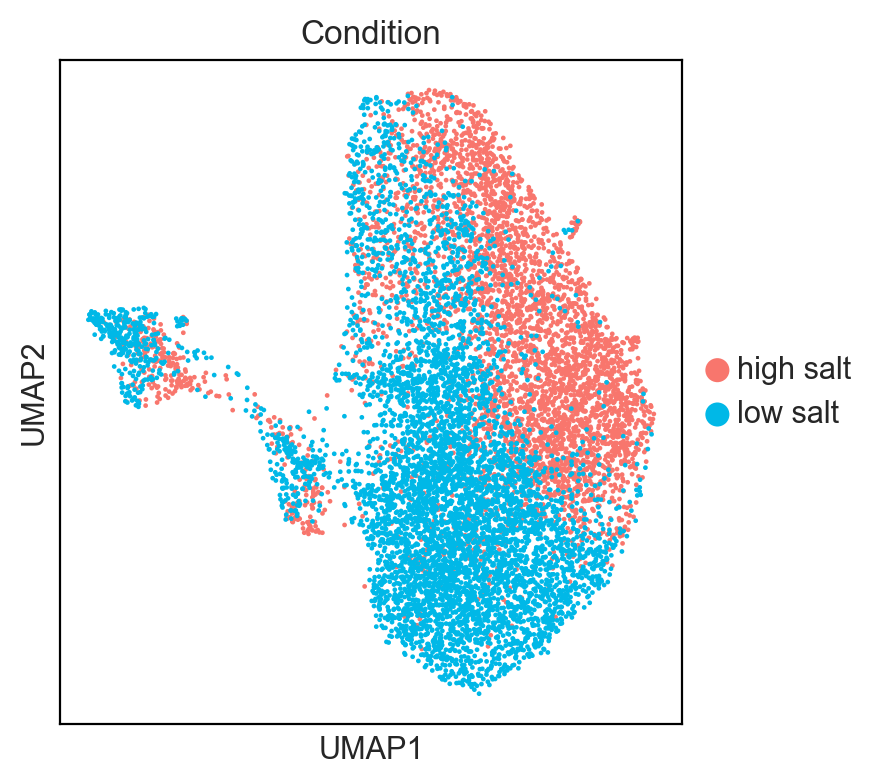

In [13]:
#UMAP
sc.tl.umap(adata)

sc.pl.scatter(
    adata,
    basis="umap",
    color="Condition",
    palette=["#F8766D", "#00B8E7"],
)

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


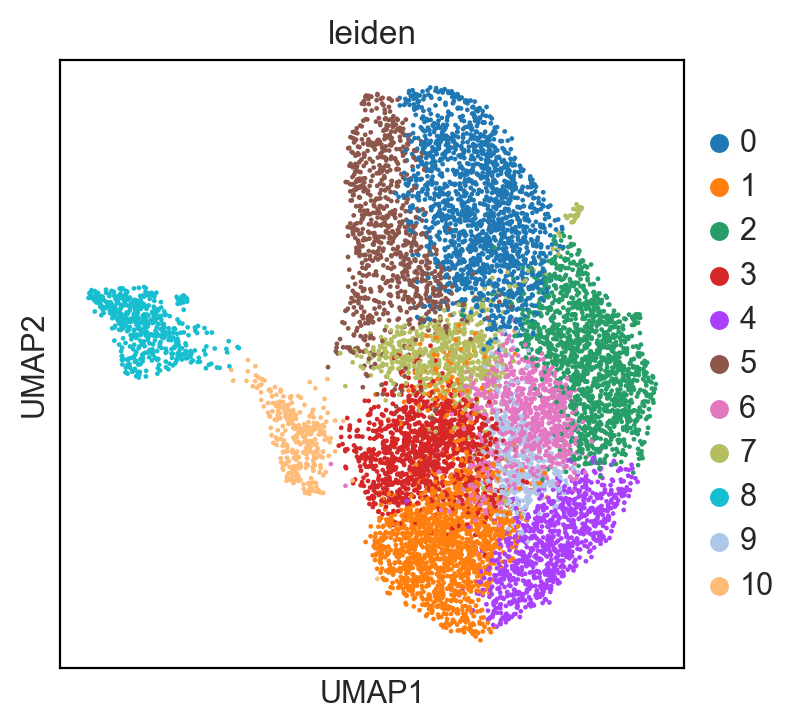

In [13]:
sc.tl.leiden(adata, resolution = 0.7)
sc.pl.umap(adata, color=['leiden'])

<b> Set TCF7 highest expressing cell as start cell <b>

In [14]:
tcf7_expression = adata[:, 'TCF7'].X
highest_expression_cell_idx = np.argmax(tcf7_expression)
highest_expression_cell = adata.obs_names[highest_expression_cell_idx]
adata.uns['iroot'] = highest_expression_cell_idx

#highest_expression_cell_idx
#highest_expression_cell

In [15]:
#Pseudotime construction
sc.tl.diffmap(adata)

In [16]:
sc.tl.dpt(adata)

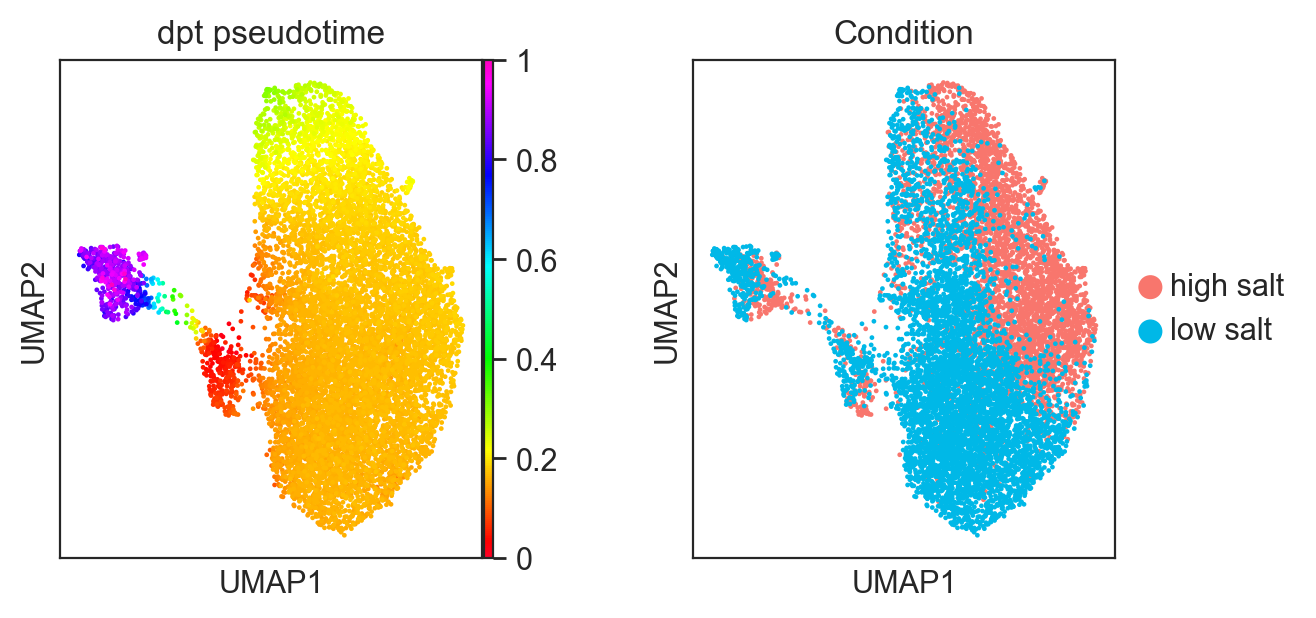

In [174]:
# Set the desired figure size
plt.rcParams["figure.figsize"] = (3, 3)  # Adjust the width and height as desired

# Create the scatter plot
sc.pl.scatter(
    adata,
    basis="umap",
    color=["dpt_pseudotime", "Condition"],
    color_map="gist_rainbow",
    save="_tcf7_dpt_and_condition.pdf"
)


In [151]:
# Subset the data for the "high salt" and "low salt" conditions
dpt_high_salt = adata.obs.loc[adata.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt = adata.obs.loc[adata.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Perform Wilcoxon rank sum test
wilcoxon_result = ranksums(dpt_high_salt, dpt_low_salt)

# Extract the p-value
p_value = wilcoxon_result.pvalue

# Check if the p-value is very small, then display in scientific notation
if p_value < 1e-4:
    p_value_str = "{:.2e}".format(p_value)
else:
    p_value_str = "{:.10f}".format(p_value)

# Print the p-value
print("P-value for the difference in dpt between high and low salt conditions:", p_value_str)

P-value for the difference in dpt between high and low salt conditions: 0.00e+00


In [177]:
# Perform Wilcoxon rank sum test and extract p-value
sc.tl.rank_genes_groups(adata, groupby="Condition", use_raw=False, method="wilcoxon")
p_value = adata.uns["rank_genes_groups"]["pvals_adj"][1]  # Assuming "high_salt" is group 0 and "low_salt" is group 1

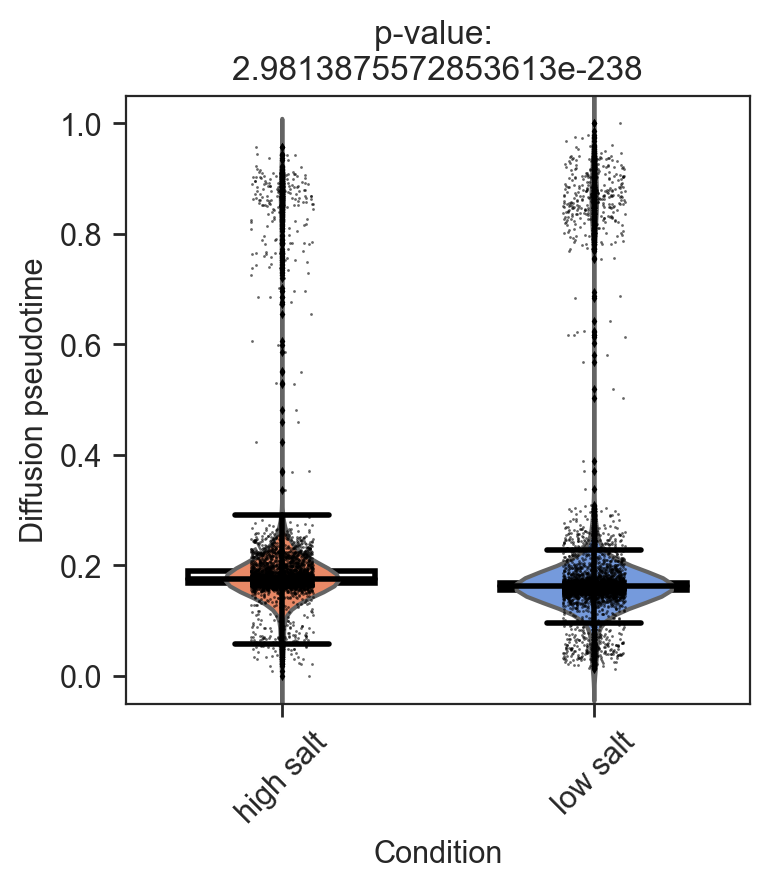

In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Subset the data for the "high salt" and "low salt" conditions
dpt_high_salt = adata.obs.loc[adata.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt = adata.obs.loc[adata.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Create a DataFrame with the condition and dpt_pseudotime columns
df = pd.DataFrame({
    'Condition': ['high salt'] * len(dpt_high_salt) + ['low salt'] * len(dpt_low_salt),
    'dpt_pseudotime': list(dpt_high_salt) + list(dpt_low_salt)
})

# Set the figure size
plt.figure(figsize=(4, 4))

# Create the violinplot with custom colors
sns.violinplot(
    x="Condition",
    y="dpt_pseudotime",
    data=df,
    inner=None,
    palette=['coral', 'cornflowerblue'],
    scale="count",
    width=0.5,
    linewidth=1.5
)

# Add jitter points
sns.stripplot(
    x="Condition",
    y="dpt_pseudotime",
    data=df,
    jitter=True,
    color='black',
    alpha=0.6,
    size=1
)

# Create the boxplot
sns.boxplot(
    x="Condition",
    y="dpt_pseudotime",
    data=df,
    width=0.6,
    color="black",
    fliersize=1,
    whis=5,
    linewidth=2,
    boxprops={'edgecolor': 'black', 'facecolor': 'None'},
    medianprops={'color': 'black', 'linewidth': 2}
)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.ylabel("Diffusion pseudotime")

plt.title("p-value: \n" + str(p_value[1]))

# Save the plot including the title
plt.savefig("tcf7_high_and_low_salt.pdf", bbox_inches="tight")

# Show the plot
plt.show()


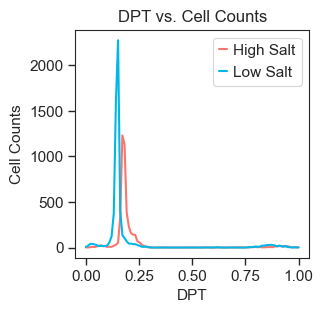

In [26]:
# Subset the data for the "high_salt" and "low_salt" conditions
dpt_high_salt = adata.obs.loc[adata.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt = adata.obs.loc[adata.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Calculate the cell counts for high salt and low salt conditions
cell_counts_high_salt = np.histogram(dpt_high_salt, bins=100)[0]
cell_counts_low_salt = np.histogram(dpt_low_salt, bins=100)[0]

# Set the figure size
plt.figure(figsize=(3, 3))

# Generate the x-axis values for the plot
x = np.linspace(min(dpt_high_salt.min(), dpt_low_salt.min()), max(dpt_high_salt.max(), dpt_low_salt.max()), num=100)

# Plot the curves for high salt and low salt conditions
plt.plot(x, cell_counts_high_salt, label="High Salt", color='#F8766D')
plt.plot(x, cell_counts_low_salt, label="Low Salt", color='#00B8E7')

# Set plot title and axis labels
plt.title("DPT vs. Cell Counts")
plt.xlabel("DPT")
plt.ylabel("Cell Counts")

# Add legend
plt.legend()

# Show the plot
plt.show()


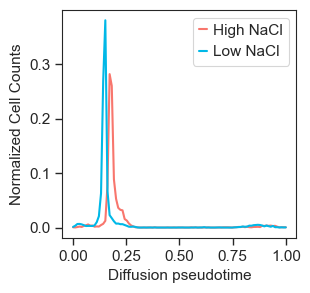

In [21]:
# Subset the data for the "high_salt" and "low_salt" conditions
dpt_high_salt = adata.obs.loc[adata.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt = adata.obs.loc[adata.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Calculate the cell counts for high salt and low salt conditions
cell_counts_high_salt = np.histogram(dpt_high_salt, bins=100)[0]
cell_counts_low_salt = np.histogram(dpt_low_salt, bins=100)[0]

# Normalize the cell counts
normalized_cell_counts_high_salt = cell_counts_high_salt / np.sum(cell_counts_high_salt)
normalized_cell_counts_low_salt = cell_counts_low_salt / np.sum(cell_counts_low_salt)

# Generate the x-axis values for the plot
x = np.linspace(min(dpt_high_salt.min(), dpt_low_salt.min()), max(dpt_high_salt.max(), dpt_low_salt.max()), num=100)

# Set the figure size
plt.figure(figsize=(3, 3))

# Plot the curves for high salt and low salt conditions with normalized cell counts
plt.plot(x, normalized_cell_counts_high_salt, label="High NaCl", color='#F8766D')
plt.plot(x, normalized_cell_counts_low_salt, label="Low NaCl", color='#00B8E7')

# Set plot axis labels
plt.xlabel("Diffusion pseudotime")
plt.ylabel("Normalized Cell Counts")

# Add legend
plt.legend()

# Save the plot as a PDF file
plt.savefig("_tcf7_dpt_normalized_cell_counts.pdf", bbox_inches="tight", dpi=300)

# Show the plot
plt.show()

In [27]:
high_salt_cells = adata[(adata.obs['Condition'] == 'high salt') & (adata.obs['dpt_pseudotime'] > 0.8)]
low_salt_cells = adata[(adata.obs['Condition'] == 'low salt') & (adata.obs['dpt_pseudotime'] > 0.8)]

high_salt_count = len(high_salt_cells)
low_salt_count = len(low_salt_cells)

print("High Salt Cells with DPT > 0.8:", high_salt_count)
print("Low Salt Cells with DPT > 0.8:", low_salt_count)

High Salt Cells with DPT > 0.8: 135
Low Salt Cells with DPT > 0.8: 291


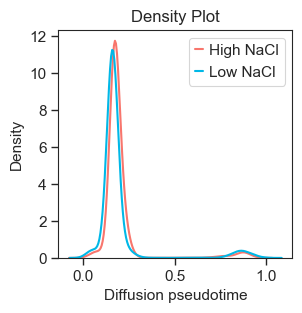

In [25]:
dpt_high_salt = adata.obs.loc[adata.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt = adata.obs.loc[adata.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Set the figure size
plt.figure(figsize=(3, 3))

# Create density plots for high salt and low salt conditions
sns.kdeplot(data=dpt_high_salt, label="High NaCl", color='#F8766D', common_norm=True)
sns.kdeplot(data=dpt_low_salt, label="Low NaCl", color='#00B8E7' , common_norm=True)

# Set plot title and axis labels
plt.title("Density Plot")
plt.xlabel("Diffusion pseudotime")
plt.ylabel("Density")

# Add legend
plt.legend()

# Save the plot as a PDF file
plt.savefig("tcf7_dpt_density.pdf", bbox_inches="tight")

# Show the plot
plt.show()


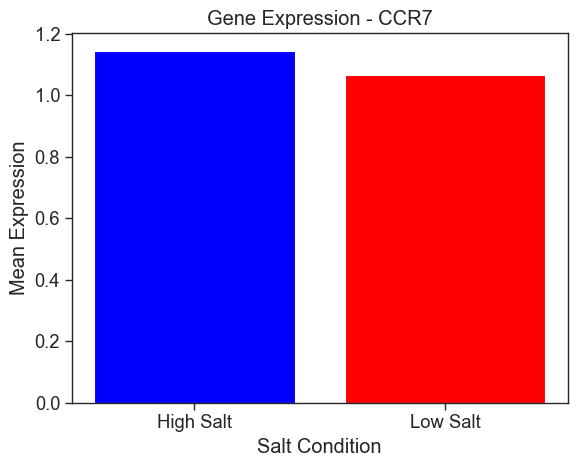

In [47]:
# Subset the data for high salt and low salt conditions
high_salt_expression = adata[adata.obs['Condition'] == 'high salt'].obs_vector(gene)
low_salt_expression = adata[adata.obs['Condition'] == 'low salt'].obs_vector(gene)

# Calculate the mean expression for each condition
mean_high_salt_expression = high_salt_expression.mean()
mean_low_salt_expression = low_salt_expression.mean()

# Set up the bar plot
fig, ax = plt.subplots()
conditions = ['High Salt', 'Low Salt']
expression_means = [mean_high_salt_expression, mean_low_salt_expression]
colors = ['blue', 'red']

# Create the bar plot
ax.bar(conditions, expression_means, color=colors)

# Set plot title and axis labels
ax.set_title(f'Gene Expression - {gene}')
ax.set_xlabel('Salt Condition')
ax.set_ylabel('Mean Expression')

# Show the plot
plt.show()


c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


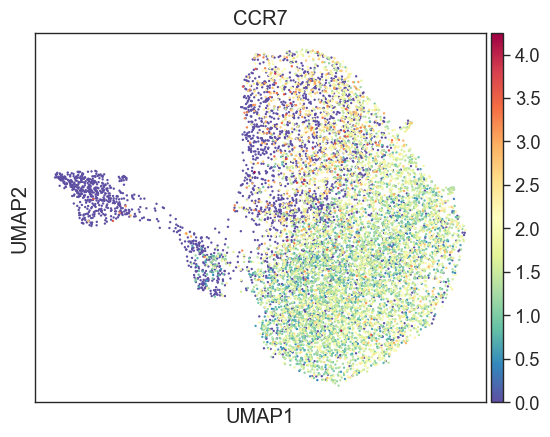

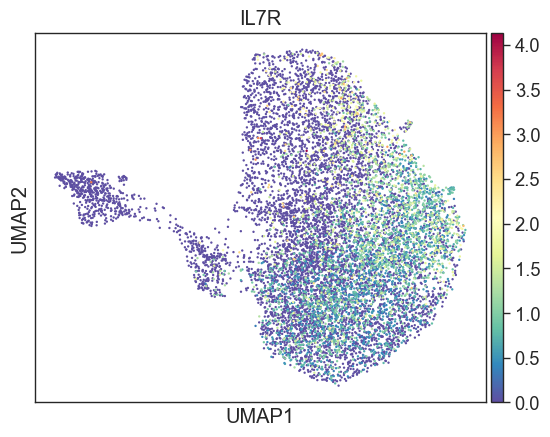

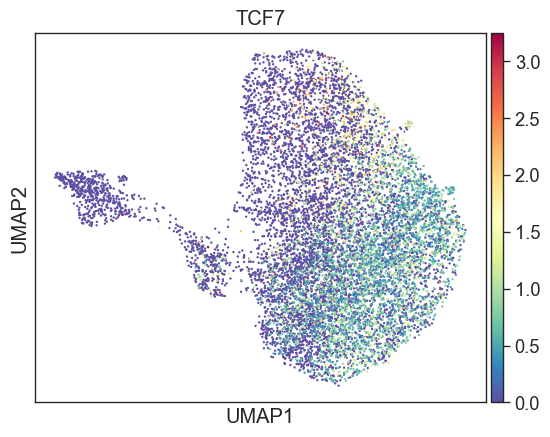

In [53]:
# Define the genes of interest
genes = ['CCR7', 'IL7R', 'TCF7']

# Subset the data for the genes of interest
adata_subset = adata[:, genes]

# Compute UMAP for the subsetted data
sc.tl.umap(adata_subset)

# Plot UMAPs for each gene
for gene in genes:
    sc.pl.umap(adata_subset, color=gene)


<b> Set the cell with highest average expression of stemness geneset as start cell <b> 

In [158]:
adata_2 = adata.copy()

geneset = ["CCL5","PLAC8","HCST","MALAT1","NKG7","SHISA5","S100A4","ACTG1","S100A11","CXCR6","S100A6","NPC2","CTLA2A","EPSTI1","GIMAP5","SEPW1","OGT","ID2","BTG1","YPEL3","CTLA2B","IFI27L2A","SAMHD1","WDR95","EVA1B","SDCBP2","LZTFL1","LY6C2","HIST1H2AP","TOP2A","HIST1H1B","NUSAP1","2810417H13RIK","TUBA1B","CDK1","SMC2","RRM2","PRC1","H2AFX","ASF1B","SPC25","ESCO2","STMN1","HIST1H2AE","MKI67","TMPO","FBXO5","TUBB5","AURKB","SGOL1","MXD3","CLSPN","UBE2S","HIST1H1E","PTMA","GMNN","CIT","CASC5","CENPF","LIG1","INCENP","SPC24","NEIL3","TPX2","TUBB4B","MIS18BP1","HMGB2","SMC4","SKA1","CCNA2","RAD51AP1","TYMS","HIST1H2AK","CKS2","KIF22","DEK","CENPE","CDCA8","CKS1B","KIF11","HJURP","TK1","CDCA2","NCAPG","RRM1","HMGB1","KIF20B","TUBA1C","NUCKS1","RFC4","ANP32B","ALYREF","TACC3","HMMR","EZH2","AURKA","PLK1","BIRC5","SHCBP1","NCAPH","SGOL2A","PBK","DUT","RAD51","KPNA2","CKAP2L","ANP32E","KIF4","RANBP1","CCDC34","SRSF7","NCAPD2","H2AFZ","LMNB1","CDCA3","CENPH","NDC80","HIST1H4D","KIF23","DHFR","SNRPD1","CBX5","NUF2","CDCA5","CENPK","CDKN2C","NCAPD3","TIPIN","LOCKD","PLK4","DNMT1","HNRNPAB","MCM5","NCAPG2","SYCE2","DBF4","ARHGAP11A","RFC3","PRIM1","CCNB1","UHRF1","PCNA","CEP55","MAD2L1","KIF15","DLGAP5","SLBP","MIS18A","NASP","SUMO2","MCM7","APITD1","ATAD2","HAUS4","TCF19","RAN","CDC20","RFC5","RAD21","PMF1","CENPM","USP1","CKAP5","BUB3","LSM3","HSP90AA1","UBE2C","HIST1H4I","SIVA1","CALM2","SMC1A","BRD8","RACGAP1","DTYMK","TUBG1","SRSF3","CENPA","GINS2","SRSF2","DNAJC9","ARL6IP1","CMC2","REEP4","ERH","LSM2","SUZ12","MCM3","CDC25B","TOPBP1","DCTPP1","SETD8","CENPW","WDR76","NRM","NAP1L1","HELLS","FABP5","ORC6","NXT1","AARS","NUDC","HAT1","BAZ1B","SSRP1","RFC1","RNASEH2B","CCNB2","CDKN2D","RBBP7","RPA3","SMC3","HMGN2","SET","WBP5","FAM111A","RBBP4","UCHL5","SMC6","HN1","BANF1","RFC2","MRPL18","CSRP1","HNRNPD","EXOSC8","HDGF","NCL","CDK4","SUPT16","PSIP1","UBB","PA2G4","SNRNP70","CBX3","LYAR","1810037I17RIK","TAGLN2","NRGN","SMARCA5","CTCF","CBX1","DDX39","SERPINB9","EIF5A","H2AFV","1500009L16RIK","CENPA","HMGB2","CCNB2","H2AFZ","BIRC5","CDKN3","CKS1B","H2AFV","CDCA3","LSM5","HMGB1","HMGN2","EMP3","RAN","STMN1","HMGB3","PTMA","ANP32E","FKBP2","2700094K13RIK","CDC20","HP1BP3","CDCA8","KNSTRN","DYNLL1","CCNB1","CENPW","1500009L16RIK","HDGF","HSP90B1","CWC15","MAD2L1","LOCKD","RDM1","SEC11C","HIST1H2BC","ANXA2","CDK2AP2","CCNA2","PMF1","NUCKS1","PTTG1","2810001G20RIK","1700097N02RIK","CKS2","GZMK","HMMR","HMGN5","TCF7","ID3","TNFSF8","TESPA1","RGS10","SLAMF6","RPS29","XCL1","RPL36","RPLP1","RPL27A","2310001H17RIK","RPS27","RPL13","RPL37A","RPL35A","RPS28","RPS18","RPL37","RPL17","RPS27A","RPS12","TNFRSF25","RPL36A","RPS14","RPS19","RPS20","RPL32","RPS23","RPL18A","RPL35","RPLP0","RPS16","RPL18","RPL26","RPL9","RPL15","RPL22","RPS9","RPL11","RPS15","RPL10","ASAP1","EVL","RPS24","RPS7","RPS3A1","RPS6","RPS26","RPL23","RPL12","RPL28","RPL23A","RPS25","RPL4","GM10073","RPL10A","RPL3","TNFRSF4","EEF1A1","RPL31","RPL21","LTB","NPM1","1810041H14RIK","TMSB10","HSPE1","IKZF2","RPS17","CD200","EEF1B2","INPP4B","LIMD2","TOX","RPS12-PS3","ADK","POU2F2","ITGB1","MIR155HG","PDCD4","EMB","ZFOS1","IFNAR2","CD160","SESN3","MS4A4C","BCL2","MRPS6","BATF","RPL10-PS3","FAM104A","CRTAM","SIAH2","FAM162A","GRCC10","TNFAIP8","NFKBIA","TRAF1","CCDC28B","ZFP36L1","GM2000","PEBP1","NRP1","MALAT1","RPL36-PS3","CD9","RPL23A-PS3","PPP1R14B","REL","MAP4K4","GPR18","CTSS","MGST2","IL7R","HIF1A","CCND3"]

# Filter geneset to include only genes present in adata.var_names
filtered_geneset = [gene for gene in geneset if gene in adata_2.var_names]

# Update geneset with the filtered genes
geneset = filtered_geneset

# Set highest average expressing cell
average_expression = np.mean(adata_2[:, geneset].X, axis=1)
highest_expression_cell_idx = np.argmax(average_expression)
adata_2.uns['iroot'] = highest_expression_cell_idx


In [159]:
#Pseudotime construction
sc.tl.diffmap(adata_2)

In [160]:
sc.tl.dpt(adata_2)

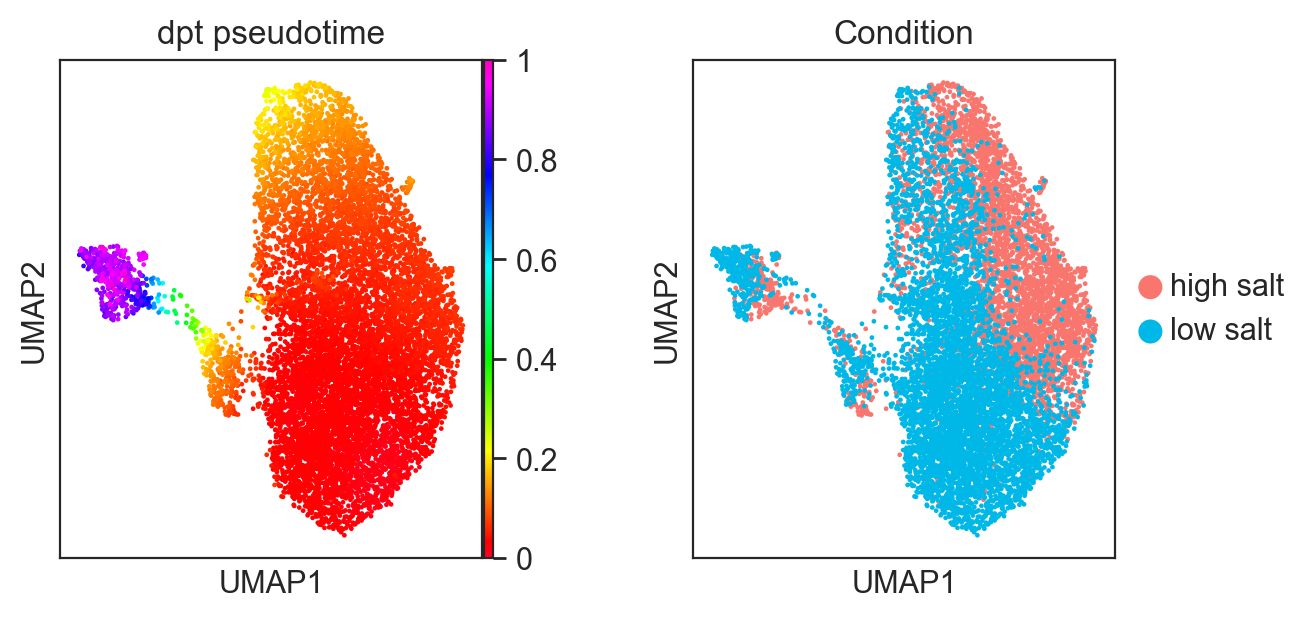

In [175]:
# Set the desired figure size
plt.rcParams["figure.figsize"] = (3, 3)  # Adjust the width and height as desired

# Create the scatter plot
sc.pl.scatter(
    adata_2,
    basis="umap",
    color=["dpt_pseudotime", "Condition"],
    color_map="gist_rainbow",
    save="_stemness_dpt_and_condition.pdf"
)


In [161]:
# Perform Wilcoxon rank sum test and extract p-value
sc.tl.rank_genes_groups(adata_2, groupby="Condition", use_raw=False, method="wilcoxon")
p_value_2 = adata_2.uns["rank_genes_groups"]["pvals_adj"][1]  # Assuming "high_salt" is group 0 and "low_salt" is group 1

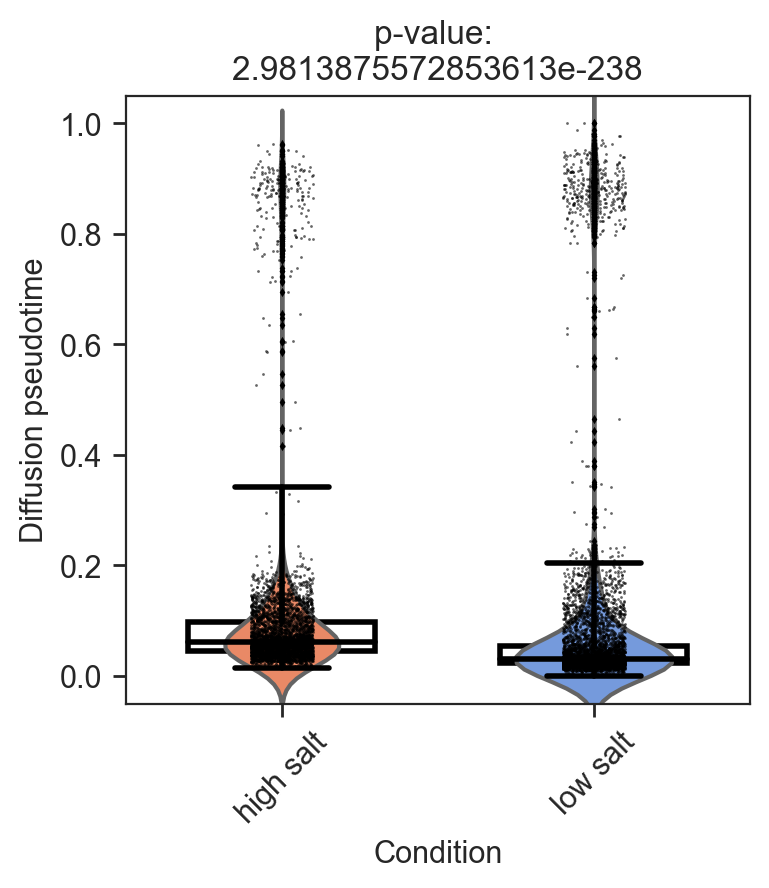

In [168]:
# Subset the data for the "high salt" and "low salt" conditions
dpt_high_salt_2 = adata_2.obs.loc[adata_2.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt_2 = adata_2.obs.loc[adata_2.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Create a DataFrame with the condition and dpt_pseudotime columns
df_2 = pd.DataFrame({
    'Condition': ['high salt'] * len(dpt_high_salt_2) + ['low salt'] * len(dpt_low_salt_2),
    'dpt_pseudotime': list(dpt_high_salt_2) + list(dpt_low_salt_2)
})

# Set the figure size
plt.figure(figsize=(4, 4))

# Create the violinplot with custom colors
sns.violinplot(
    x="Condition",
    y="dpt_pseudotime",
    data=df_2,
    inner=None,
    palette=['coral', 'cornflowerblue'],
    scale="count",
    width=0.5,
    linewidth=1.5
)

# Add jitter points
sns.stripplot(
    x="Condition",
    y="dpt_pseudotime",
    data=df_2,
    jitter=True,
    color='black',
    alpha=0.6,
    size=1
)

# Create the boxplot
sns.boxplot(
    x="Condition",
    y="dpt_pseudotime",
    data=df_2,
    width=0.6,
    color="black",
    fliersize=1,
    whis=5,
    linewidth=2,
    boxprops={'edgecolor': 'black', 'facecolor': 'None'},
    medianprops={'color': 'black', 'linewidth': 2}
)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.ylabel("Diffusion pseudotime")

plt.title("p-value: \n" + str(p_value_2[1]))

# Save the plot including the title
plt.savefig("stemness_high_and_low_salt.pdf", bbox_inches="tight")

# Show the plot
plt.show()


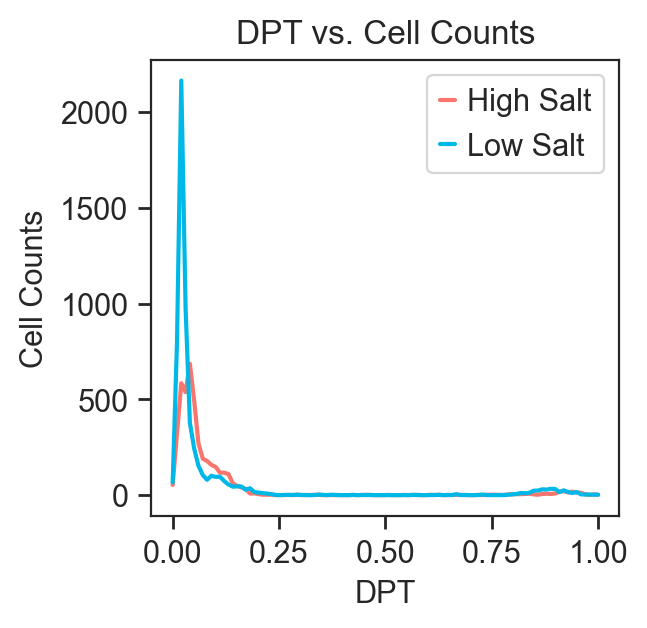

In [169]:
# Subset the data for the "high_salt" and "low_salt" conditions
dpt_high_salt = adata_2.obs.loc[adata_2.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt = adata_2.obs.loc[adata_2.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Set the figure size
plt.figure(figsize=(3, 3))

# Calculate the cell counts for high salt and low salt conditions
cell_counts_high_salt = np.histogram(dpt_high_salt, bins=100)[0]
cell_counts_low_salt = np.histogram(dpt_low_salt, bins=100)[0]

# Generate the x-axis values for the plot
x = np.linspace(min(dpt_high_salt.min(), dpt_low_salt.min()), max(dpt_high_salt.max(), dpt_low_salt.max()), num=100)

# Plot the curves for high salt and low salt conditions
plt.plot(x, cell_counts_high_salt, label="High Salt", color='#F8766D')
plt.plot(x, cell_counts_low_salt, label="Low Salt", color='#00B8E7')

# Set plot title and axis labels
plt.title("DPT vs. Cell Counts")
plt.xlabel("DPT")
plt.ylabel("Cell Counts")

# Add legend
plt.legend()

# Show the plot
plt.show()


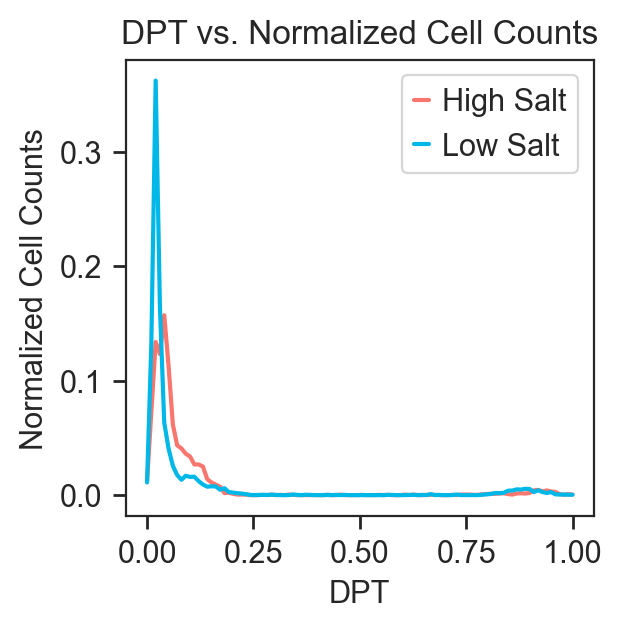

In [170]:
# Subset the data for the "high_salt" and "low_salt" conditions
dpt_high_salt = adata_2.obs.loc[adata_2.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt = adata_2.obs.loc[adata_2.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Set the figure size
plt.figure(figsize=(3, 3))

# Calculate the cell counts for high salt and low salt conditions
cell_counts_high_salt = np.histogram(dpt_high_salt, bins=100)[0]
cell_counts_low_salt = np.histogram(dpt_low_salt, bins=100)[0]

# Normalize the cell counts
normalized_cell_counts_high_salt = cell_counts_high_salt / np.sum(cell_counts_high_salt)
normalized_cell_counts_low_salt = cell_counts_low_salt / np.sum(cell_counts_low_salt)

# Generate the x-axis values for the plot
x = np.linspace(min(dpt_high_salt.min(), dpt_low_salt.min()), max(dpt_high_salt.max(), dpt_low_salt.max()), num=100)

# Plot the curves for high salt and low salt conditions with normalized cell counts
plt.plot(x, normalized_cell_counts_high_salt, label="High Salt", color='#F8766D')
plt.plot(x, normalized_cell_counts_low_salt, label="Low Salt", color='#00B8E7')

# Set plot title and axis labels
plt.title("DPT vs. Normalized Cell Counts")
plt.xlabel("DPT")
plt.ylabel("Normalized Cell Counts")

# Add legend
plt.legend()

# Save the plot as a PDF file
plt.savefig("stemness_dpt_normalized_cell_counts.pdf", bbox_inches="tight")

# Show the plot
plt.show()


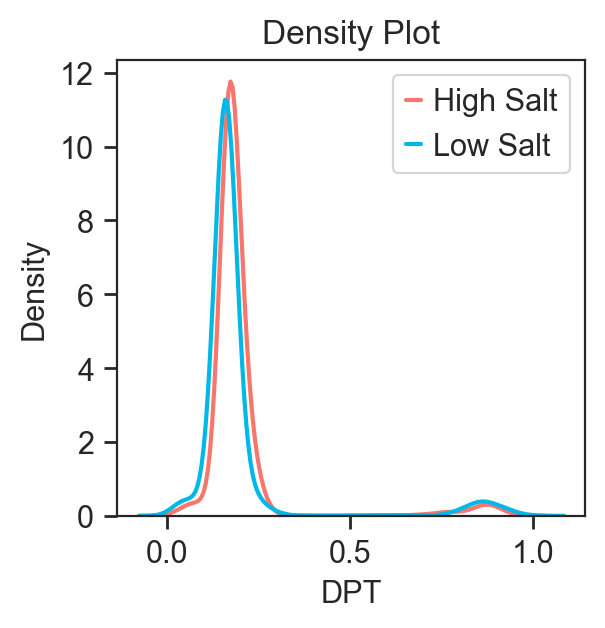

In [171]:
dpt_high_salt = adata.obs.loc[adata.obs['Condition'] == 'high salt', 'dpt_pseudotime']
dpt_low_salt = adata.obs.loc[adata.obs['Condition'] == 'low salt', 'dpt_pseudotime']

# Set the figure size
plt.figure(figsize=(3, 3))

# Create density plots for high salt and low salt conditions
sns.kdeplot(data=dpt_high_salt, label="High Salt", color='#F8766D', common_norm=True)
sns.kdeplot(data=dpt_low_salt, label="Low Salt", color='#00B8E7' , common_norm=True)

# Set plot title and axis labels
plt.title("Density Plot")
plt.xlabel("DPT")
plt.ylabel("Density")

# Add legend
plt.legend()

# Show the plot
plt.show()


Velocity for high and low salt 

In [17]:
# Standard scvelo processing to run Dynamical Mode
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:11) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


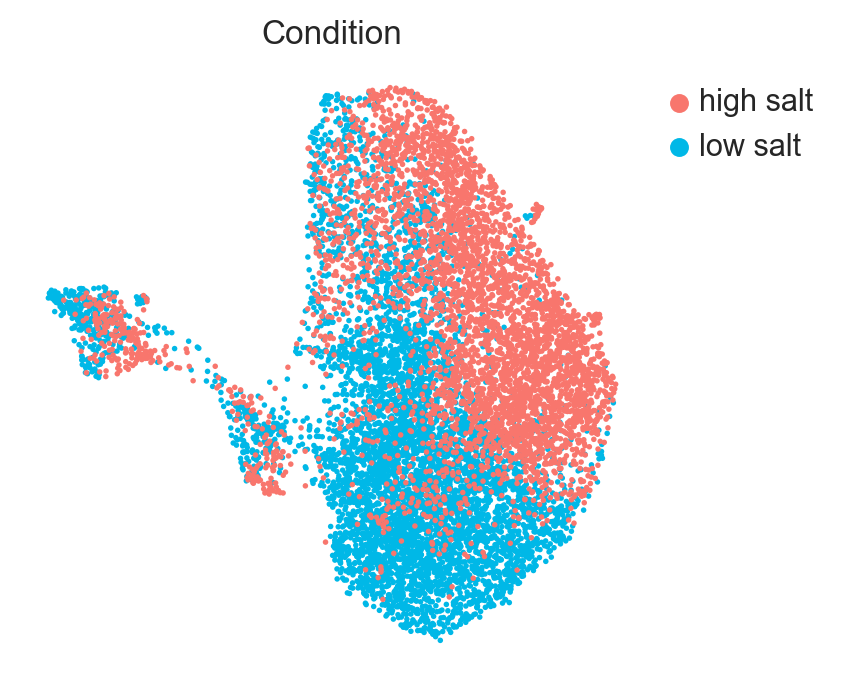

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


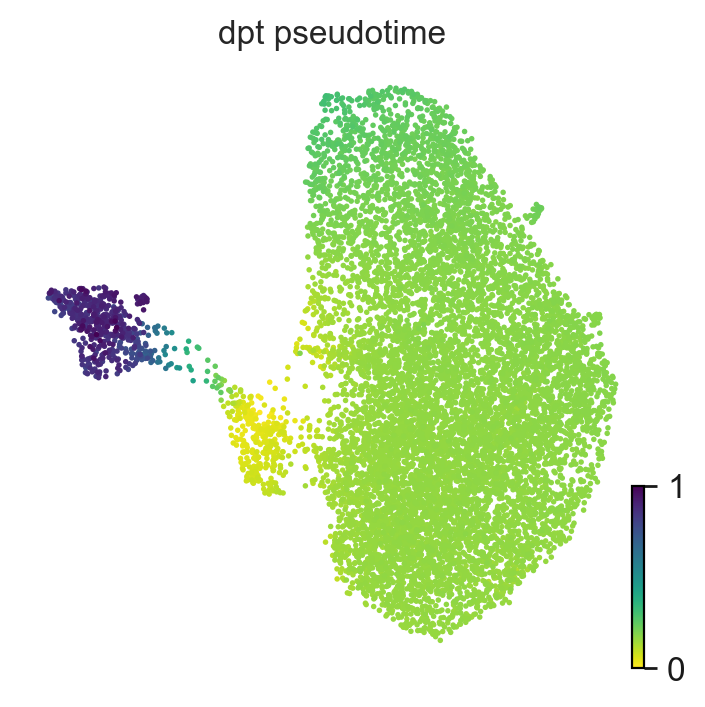

In [18]:
scv.tl.umap(adata)
scv.pl.scatter(adata, basis="umap", color="Condition")
scv.pl.scatter(adata, basis="umap", color="dpt_pseudotime")

In [18]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:01:35) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/8 cores)


  0%|          | 0/10343 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


figure cannot be saved as pdf, using png instead.
saving figure to file ./figures/scvelo_scVelo-umap-cluster_high_and_low_salt.png


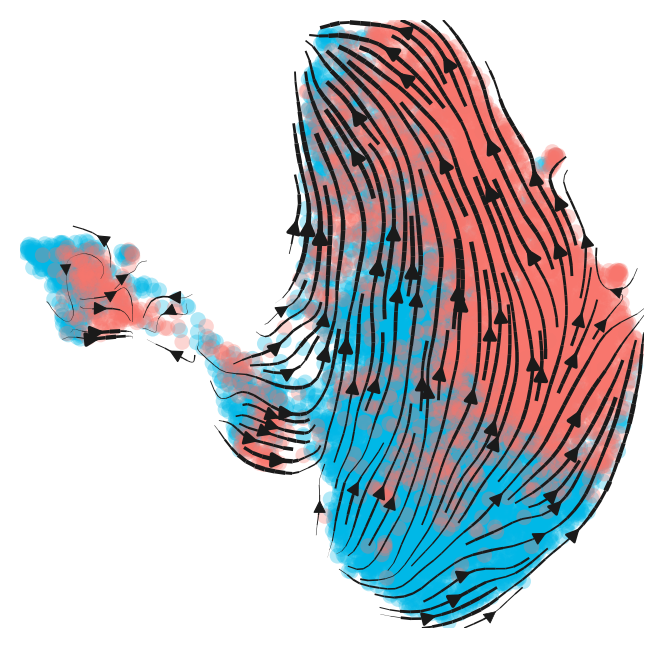

In [31]:
adata.obs['Condition'].replace('high salt', 'High NaCl', inplace=True)
adata.obs['Condition'].replace('low salt', 'Low NaCl', inplace=True)


scv.pl.velocity_embedding_stream(adata, basis="umap", color="Condition", legend_loc= 'none', title="", save='scVelo-umap-cluster_high_and_low_salt.pdf')

c:\Users\mahim\AppData\Local\Programs\Python\Python39\lib\site-packages\scvelo\plotting\utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


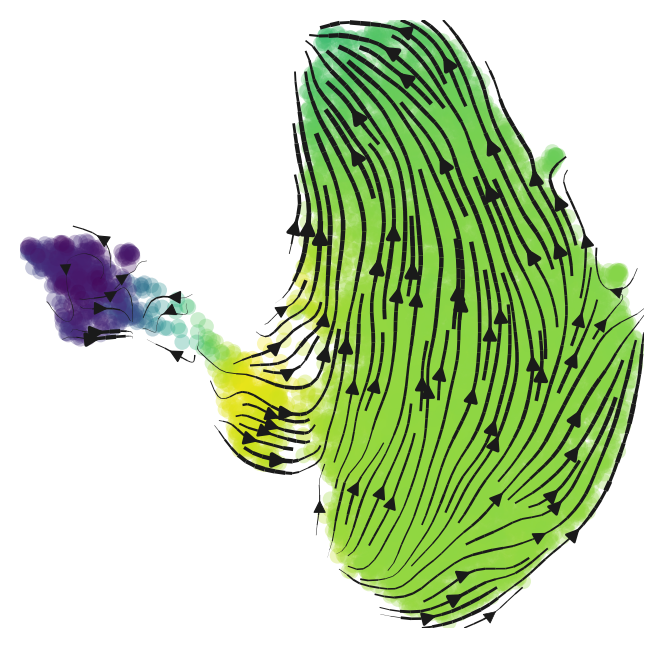

In [30]:
# Generate the velocity embedding stream plot
scv.pl.velocity_embedding_stream(adata, basis="umap", color="dpt_pseudotime", palette='gist_rainbow', title="", show=False)

# Remove the colorbar
plt.gcf().axes[-1].remove()

# Save the plot
plt.savefig('scVelo-umap-dpt.png', bbox_inches='tight')

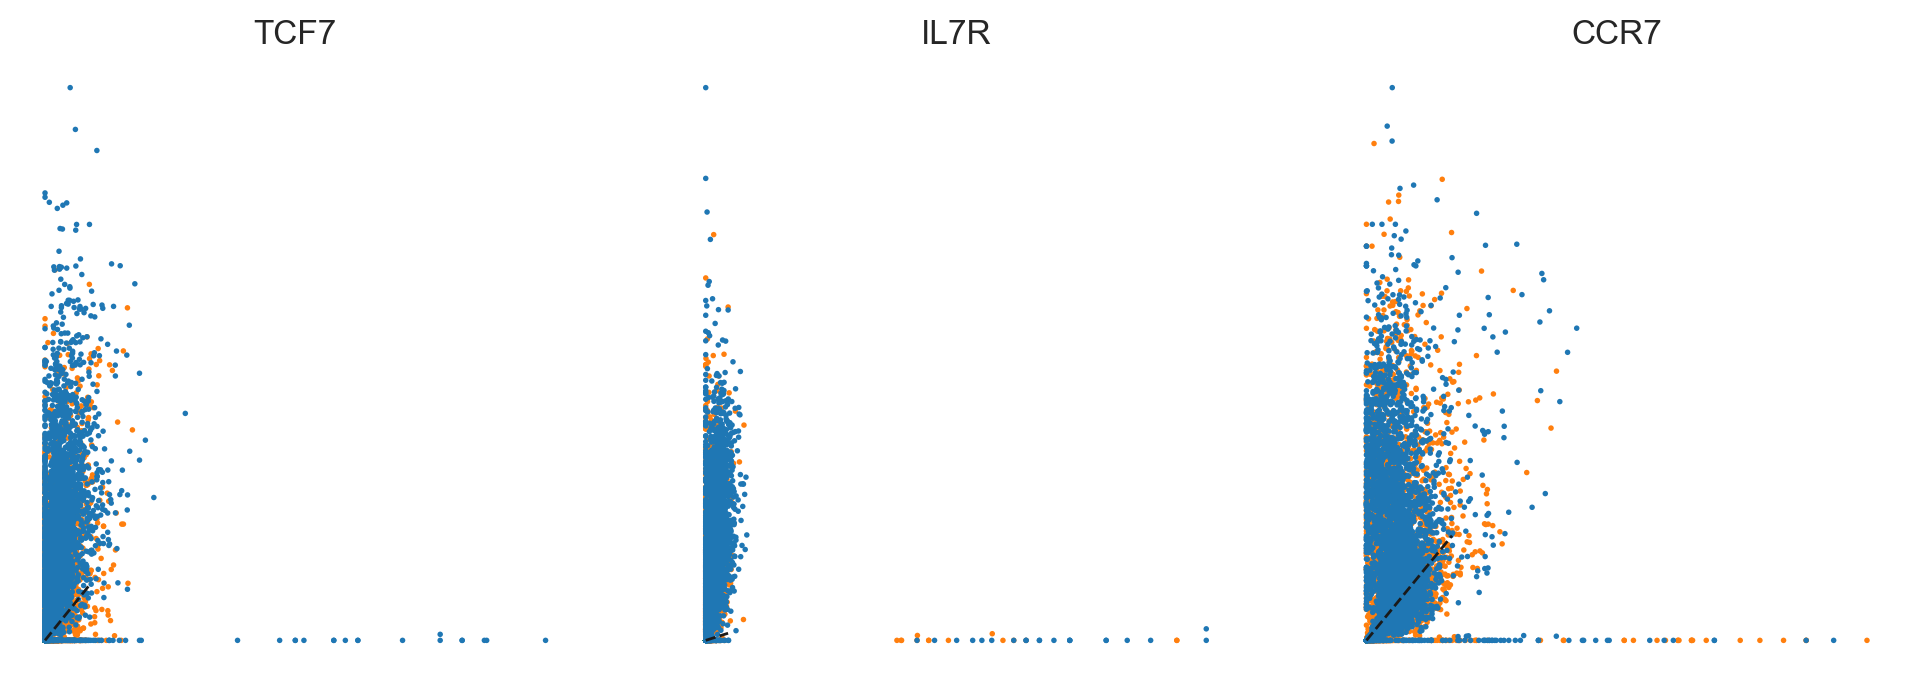

In [18]:
top_genes = ["TCF7", "IL7R", "CCR7"]
scv.pl.scatter(adata, basis=top_genes, color="Condition", frameon=False)

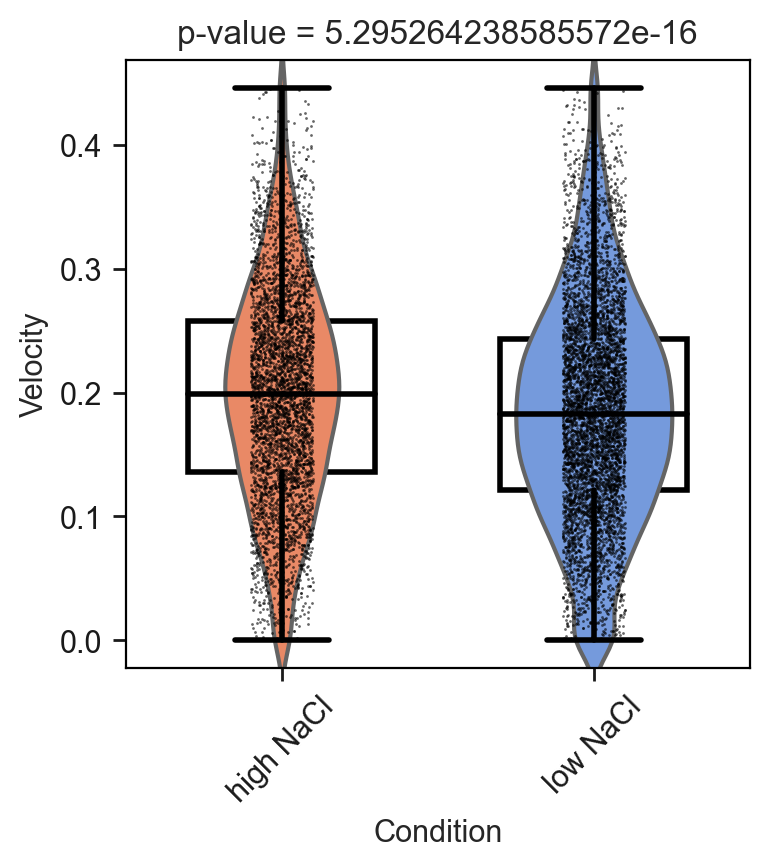

In [31]:
# Subset the data for the "high salt" and "low salt" conditions
dpt_high_salt = adata.obs.loc[adata.obs['Condition'] == 'high salt', 'velocity_self_transition']
dpt_low_salt = adata.obs.loc[adata.obs['Condition'] == 'low salt', 'velocity_self_transition']

# Create a DataFrame with the condition and velocity_self_transition columns
df = pd.DataFrame({
    'Condition': ['high NaCl'] * len(dpt_high_salt) + ['low NaCl'] * len(dpt_low_salt),
    'velocity_self_transition': list(dpt_high_salt) + list(dpt_low_salt)
})

# Perform Wilcoxon rank sum test
statistic, p_value = ranksums(dpt_high_salt, dpt_low_salt)

# Set the figure size
plt.figure(figsize=(4, 4))

# Create the violinplot with custom colors
sns.violinplot(
    x="Condition",
    y="velocity_self_transition",
    data=df,
    inner=None,
    palette=['coral', 'cornflowerblue'],
    scale="count",
    width=0.5,
    linewidth=1.5
)

# Add jitter points
sns.stripplot(
    x="Condition",
    y="velocity_self_transition",
    data=df,
    jitter=True,
    color='black',
    alpha=0.6,
    size=1
)

# Create the boxplot
sns.boxplot(
    x="Condition",
    y="velocity_self_transition",
    data=df,
    width=0.6,
    color="black",
    fliersize=1,
    whis=5,
    linewidth=2,
    boxprops={'edgecolor': 'black', 'facecolor': 'None'},
    medianprops={'color': 'black', 'linewidth': 2}
)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.ylabel("Velocity")

# Add p-value as title
plt.title(f"p-value = 5.295264238585572e-16")

# Save the plot including the title
plt.savefig("scVelo-violin-boxplot-latent_time.pdf", bbox_inches="tight")

# Show the plot
plt.show()


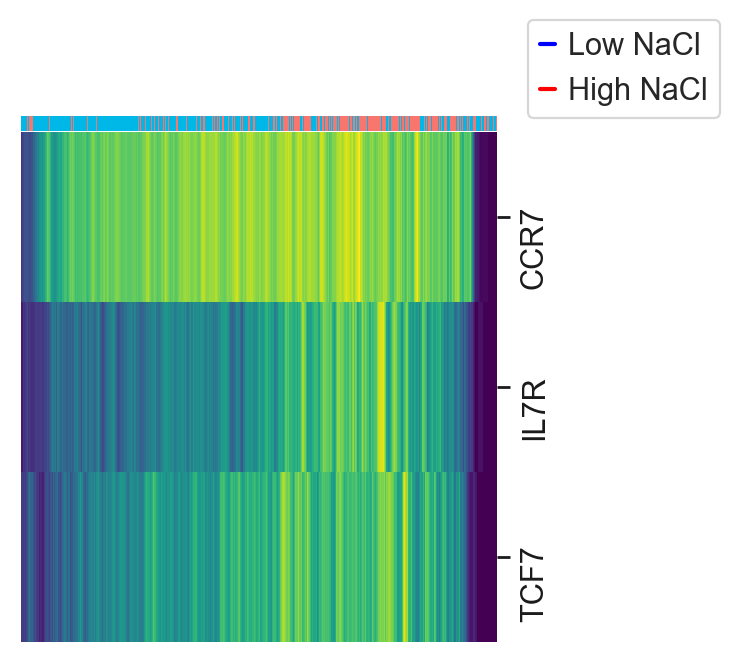

In [47]:
# Create the heatmap
scv.pl.heatmap(
    adata,
    var_names=top_genes,
    sortby='dpt_pseudotime',
    col_color='Condition',
    n_convolve=100,
    figsize=(3, 3),
    yticklabels=True,
    sort=True,
    colorbar=True,  # Set colorbar to True
    show=False,
    layer="count"
)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], color='blue', label='Low NaCl'),
    plt.Line2D([0], [0], color='red', label='High NaCl'),
    # Add more legend elements for each condition/color
]

# Place the legend outside the plot
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.25))

# Save the plot as PDF
plt.savefig('scVelo-heatmap-dpt.pdf', bbox_inches='tight')

# Show the plot
plt.show()


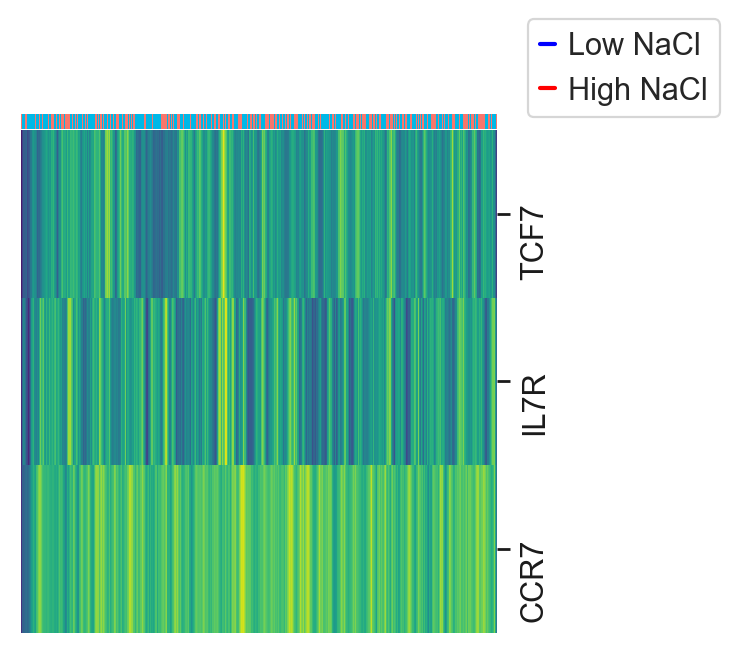

In [49]:
# Create the heatmap
scv.pl.heatmap(
    adata,
    var_names=top_genes,
    sortby='velocity_self_transition',
    col_color='Condition',
    n_convolve=100,
    figsize=(3, 3),
    yticklabels=True,
    sort=True,
    colorbar=True,  # Set colorbar to True
    show=False,
    layer="count"
)

# Add a legend
legend_elements = [
    plt.Line2D([0], [0], color='blue', label='Low NaCl'),
    plt.Line2D([0], [0], color='red', label='High NaCl'),
    # Add more legend elements for each condition/color
]

# Place the legend outside the plot
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.5, 1.25))

# Save the plot as PDF
plt.savefig('scVelo-heatmap-velocity.pdf', bbox_inches='tight')

# Show the plot
plt.show()


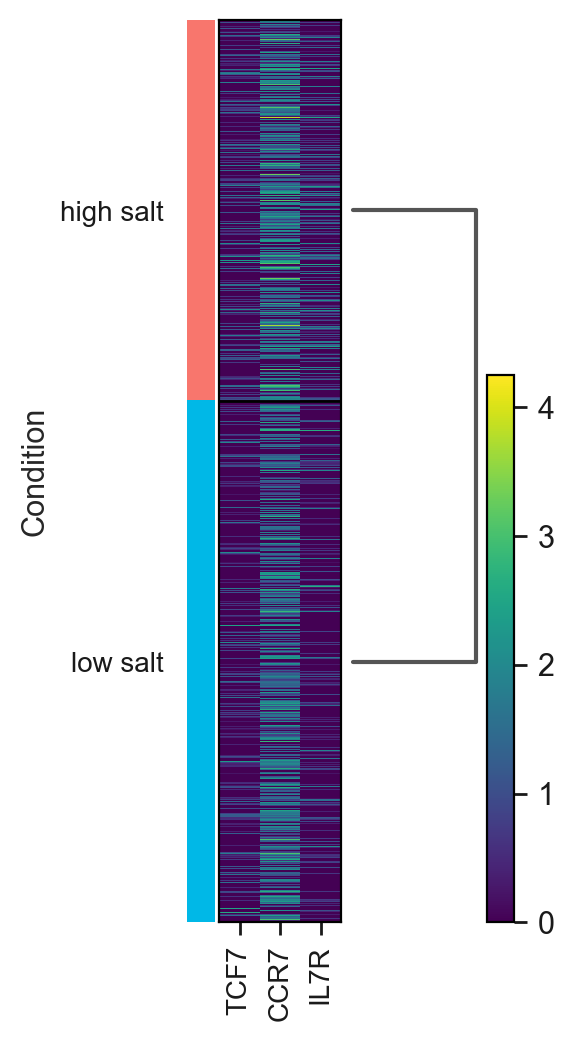

In [28]:
ax = sc.pl.heatmap(adata, top_genes, groupby='Condition', cmap='viridis', dendrogram=True)